In [8]:
#
# In this notebook we compute simple statistics
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.gridspec as gridspec
from scipy.special import logit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from global_land_mask import globe
from src.regions import *
from src.pf_stats import *
from src.plotting import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
pf_stats = load_global_pf_stats()

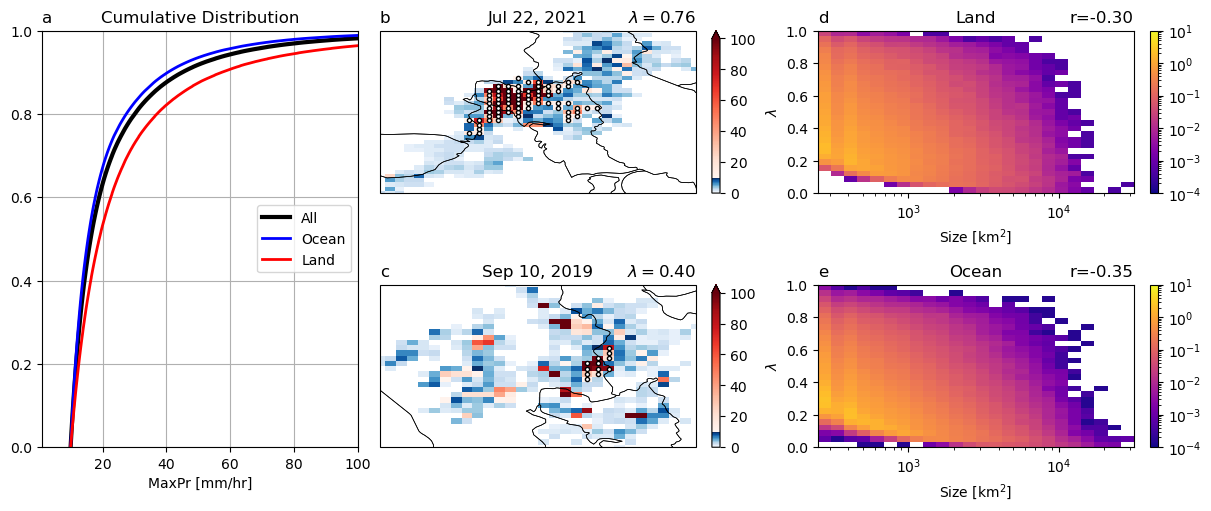

In [21]:
import numpy as np
import xarray as xr
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from scipy.stats import binned_statistic_2d, pearsonr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

##############################################################################
# 1) HELPER FUNCTIONS / DUMMY PLACEHOLDERS
##############################################################################

def cdf(data):
    """Compute the empirical CDF for a 1D NumPy array."""
    sorted_data = np.sort(data)
    return np.arange(1, len(sorted_data) + 1) / len(sorted_data)

def create_split_cmap(vmin=0, vmax=100, split=10,
                      cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    """
    Create a custom colormap transitioning from cmap_low to cmap_high
    with 'split' as the boundary.
    """
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm

# Suppose you have:
# from your_module import globe, pf_stats
# globe.is_land(...) / globe.is_ocean(...), and pf_stats is a table of feature stats
##############################################################################

##############################################################################
# 2) FIGURE SETUP
##############################################################################

# Increase the width a bit and let each subplot fill available space
fig = plt.figure(figsize=(12, 5), constrained_layout=True)

# 2 rows, 3 columns;
# widen the middle column (maps) by using [2, 3, 2] ratios
gs = gridspec.GridSpec(
    nrows=2,
    ncols=3,
    figure=fig,
    width_ratios=[2, 2, 2],
    height_ratios=[1, 1]
)

##############################################################################
# 3) LEFT PANEL (CDF of MaxPr for Land/Ocean) spanning rows
##############################################################################

ax_cdf = fig.add_subplot(gs[:, 0])

maxpr_all = pf_stats['max_precip'].values
is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

maxpr_land  = pf_stats['max_precip'][is_land_id].values
maxpr_ocean = pf_stats['max_precip'][is_ocean_id].values

ax_cdf.plot(np.sort(maxpr_all),   cdf(maxpr_all),   label='All',   lw=3, color='black')
ax_cdf.plot(np.sort(maxpr_ocean), cdf(maxpr_ocean), label='Ocean', lw=2, color='blue')
ax_cdf.plot(np.sort(maxpr_land),  cdf(maxpr_land),  label='Land',  lw=2, color='red')

ax_cdf.set_xlim(1, 100)
ax_cdf.set_ylim(0, 1)
ax_cdf.set_xlabel('MaxPr [mm/hr]')
ax_cdf.set_title('Cumulative Distribution')
ax_cdf.set_title('a', loc='left')
ax_cdf.legend(loc='center right')
ax_cdf.grid(True)

##############################################################################
# 4) MIDDLE COLUMN: TWO EXAMPLE MAPS (top/bottom)
##############################################################################

cmap_split, norm_split = create_split_cmap(
    vmin=0,
    vmax=100,
    split=10,
    cmap_low=plt.cm.Blues,
    cmap_high=plt.cm.Reds
)

# We'll plot two examples: 'high_area_high_loc' and 'high_area_low_loc'
regimes = ['high_area_high_loc', 'high_area_low_loc']
map_axes = [
    fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree()),
    fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
]

for i, (ax_map, regime) in enumerate(zip(map_axes, regimes)):
    # Ensure the map fills its allocated space
    ax_map.set_aspect("auto")

    # Load the example dataset
    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data = xr.open_dataset(pf_filename)

    # Plot near_surf_rain
    rain_plot = pf_data.near_surf_rain.plot(
        ax=ax_map,
        cmap=cmap_split,
        norm=norm_split,
        cbar_kwargs={'label': None},
        transform=ccrs.PlateCarree()
    )

    # If lon/lat are 1D
    if 'lon' in pf_data.coords:
        lon = pf_data['lon'].values
    else:
        lon = pf_data['longitude'].values

    if 'lat' in pf_data.coords:
        lat = pf_data['lat'].values
    else:
        lat = pf_data['latitude'].values

    # Zoom to data
    ax_map.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], ccrs.PlateCarree())

    # Label connected regions where rain > 10 mm/hr
    rain = pf_data.near_surf_rain.values
    mask = (rain > 10)
    structure = np.ones((3, 3))  # 8-connected
    labeled_array, num_features = ndimage.label(mask, structure=structure)

    if num_features > 0:
        region_sizes = ndimage.sum(mask, labeled_array, index=np.arange(1, num_features + 1))
        largest_region_label = np.argmax(region_sizes) + 1
        largest_region_mask = (labeled_array == largest_region_label)
        indices = np.argwhere(largest_region_mask)

        # Plot a marker for each cell in largest region
        for (i_idx, j_idx) in indices:
            ax_map.plot(
                lon[j_idx], lat[i_idx],
                marker='o', color='white', markersize=3, markeredgecolor='black',
                transform=ccrs.PlateCarree()
            )

    # Some features on the map
    ax_map.add_feature(cfeature.STATES, linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)

    # Panel labeling
    ax_map.set_title('')
    ax_map.set_title(chr(ord('b') + i), loc='left')

    # Title with date
    time_label = pf_data.time.dt.strftime('%b %d, %Y').item()
    ax_map.set_title(time_label)

    # Right-side subtitle with lambda
    lambda_val = [0.76, 0.40][i]
    ax_map.set_title(rf'$\lambda={lambda_val:.2f}$', loc='right')

##############################################################################
# 5) RIGHT COLUMN: 2D PDFs for Land (top) and Ocean (bottom)
##############################################################################

# --- Top-Right: Land ---
ax_land_pdf = fig.add_subplot(gs[0, 2])
ax_land_pdf.set_aspect('auto')  # let it fill space

area_land = pf_stats[is_land_id]['num_pixels'] * 25
loc_land  = (
    pf_stats[is_land_id]['rainiest_10mmhr_cluster_precip_8conn']
    / pf_stats[is_land_id]['total_precip']
)

area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins  = np.linspace(0, 1, 30)

count_land = binned_statistic_2d(
    x=loc_land, 
    y=area_land, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf_land = 100 * count_land / count_land.sum()
x_mesh_land, y_mesh_land = np.meshgrid(area_bins, loc_bins)

c_land = ax_land_pdf.pcolormesh(
    x_mesh_land,
    y_mesh_land,
    pdf_land,
    cmap=plt.cm.plasma,
    norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
)

fig.colorbar(c_land, ax=ax_land_pdf)
ax_land_pdf.set_xscale('log')
ax_land_pdf.set_xlim(area_bins.min(), area_bins.max())
ax_land_pdf.set_xlabel(r'Size [km$^2$]')
ax_land_pdf.set_ylabel(r'$\lambda$')
ax_land_pdf.set_title('PDF [%]')
ax_land_pdf.set_title('d', loc='left')
ax_land_pdf.set_title('Land', loc='center')
r_val_land, _ = pearsonr(area_land, loc_land)
ax_land_pdf.set_title(f'r={r_val_land:.2f}', loc='right')

# --- Bottom-Right: Ocean ---
ax_ocean_pdf = fig.add_subplot(gs[1, 2])
ax_ocean_pdf.set_aspect('auto')

area_ocean = pf_stats[is_ocean_id]['num_pixels'] * 25
loc_ocean  = (
    pf_stats[is_ocean_id]['largest_10mmhr_cluster_precip_8conn']
    / pf_stats[is_ocean_id]['total_precip']
)

count_ocean = binned_statistic_2d(
    x=loc_ocean,
    y=area_ocean,
    values=None,
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf_ocean = 100 * count_ocean / count_ocean.sum()
x_mesh_ocean, y_mesh_ocean = np.meshgrid(area_bins, loc_bins)

c_ocean = ax_ocean_pdf.pcolormesh(
    x_mesh_ocean,
    y_mesh_ocean,
    pdf_ocean,
    cmap=plt.cm.plasma,
    norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
)

fig.colorbar(c_ocean, ax=ax_ocean_pdf)
ax_ocean_pdf.set_xscale('log')
ax_ocean_pdf.set_xlim(area_bins.min(), area_bins.max())
ax_ocean_pdf.set_xlabel(r'Size [km$^2$]')
ax_ocean_pdf.set_ylabel(r'$\lambda$')
ax_ocean_pdf.set_title('PDF [%]')
ax_ocean_pdf.set_title('e', loc='left')
ax_ocean_pdf.set_title('Ocean', loc='center')
r_val_ocean, _ = pearsonr(area_ocean, loc_ocean)
ax_ocean_pdf.set_title(f'r={r_val_ocean:.2f}', loc='right')

##############################################################################
# 6) SHOW OR SAVE
##############################################################################
plt.savefig('../figures/Fig01_CDFandExamplePS.pdf', bbox_inches='tight')


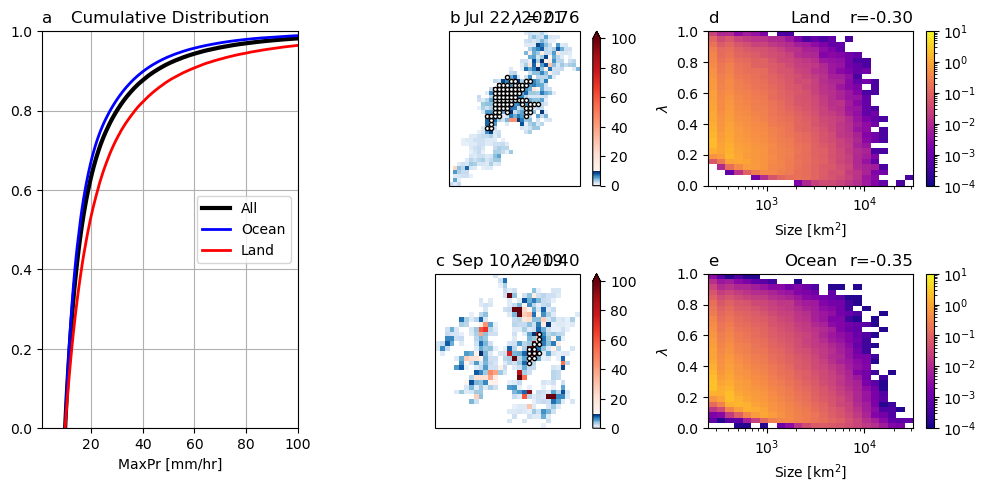

In [12]:
#
# Plot Figure 1 for paper
#
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(
    nrows=2,
    ncols=3, 
    width_ratios=[4, 4, 4],
    height_ratios=[1, 1]
)

#
# Plot CDF of MaxPr for land and ocean
#
ax = fig.add_subplot(gs[:, 0])
maxpr = pf_stats['max_precip']
is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

def cdf(data):
    sorted_data = np.sort(data)
    cdf_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return cdf_vals

maxpr_all = pf_stats['max_precip'].values
maxpr_land = pf_stats['max_precip'][is_land_id].values
maxpr_ocean = pf_stats['max_precip'][is_ocean_id].values
ax.plot(np.sort(maxpr_all), cdf(maxpr_all), label='All', lw=3, color='black')
ax.plot(np.sort(maxpr_ocean), cdf(maxpr_ocean), label='Ocean', lw=2, color='blue')
ax.plot(np.sort(maxpr_land), cdf(maxpr_land), label='Land', lw=2, color='red')

ax.set_xlim(1, 100)
ax.set_ylim(0, 1)
ax.set_xlabel('MaxPr [mm/hr]')
ax.set_title('Cumulative Distribution')
ax.set_title('a', loc='left')
ax.legend(loc='center right')
ax.grid(True)

#
# Plot high and low locs
#
def create_split_cmap(vmin=0, vmax=100, split=10, cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm

cmap_split, norm_split = create_split_cmap(
    vmin=0,
    vmax=100,
    split=10,
    cmap_low=plt.cm.Blues,
    cmap_high=plt.cm.Reds
)

ax_list = [fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree()), fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())]
regime_list = ['high_area_high_loc', 'high_area_low_loc']

for i, (ax, regime) in enumerate(zip(ax_list, regime_list)):
    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data = xr.open_dataset(pf_filename)
    pf_data.near_surf_rain.plot(
        ax=ax,
        cmap=cmap_split,
        norm=norm_split,
        cbar_kwargs={'label': None}
    )


    import scipy.ndimage as ndimage

    # Extract the precipitation field as a NumPy array
    rain = pf_data.near_surf_rain.values

    # Create a Boolean mask where rain rates exceed 10 mm/hr
    mask = rain > 10

    # Label connected regions (using an 8-connected neighborhood)
    structure = np.ones((3, 3))  # 8-connected
    labeled_array, num_features = ndimage.label(mask, structure=structure)

    if num_features > 0:
        # Compute the size of each connected region
        region_sizes = ndimage.sum(mask, labeled_array, index=np.arange(1, num_features + 1))
        # Identify the label corresponding to the largest region (labels start at 1)
        largest_region_label = np.argmax(region_sizes) + 1
        largest_region_mask = (labeled_array == largest_region_label)
        
        # Find the indices (row, col) of pixels in the largest region
        indices = np.argwhere(largest_region_mask)
        
        # Get the coordinate arrays.
        # Here we assume that pf_data has 1D coordinate arrays for longitude and latitude.
        # Adjust 'lon' and 'lat' to the correct names if different.
        lon = pf_data['lon'].values if 'lon' in pf_data.coords else pf_data['longitude'].values
        lat = pf_data['lat'].values if 'lat' in pf_data.coords else pf_data['latitude'].values
        
        # Loop over each pixel in the largest region and plot a white dot at its center.
        for i_idx, j_idx in indices:
            # Here, i_idx corresponds to the latitude index and j_idx to the longitude index.
            ax.plot(lon[j_idx], lat[i_idx], marker='o', color='white', markersize=3, markeredgecolor='black')

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title('')
    ax.set_title(chr(ord('b') + i), loc='left')
    ax.set_title(pf_data.time.dt.strftime('%b %d, %Y').item())
    ax.set_title(rf'$\lambda=${[0.76, 0.40][i]:.02f}', loc='right')
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)

#
# Plot PDF of land size and loc
#
ax = fig.add_subplot(gs[0, 2])
area = pf_stats[is_land_id]['num_pixels'] * 25
loc = pf_stats[is_land_id][f'rainiest_10mmhr_cluster_precip_8conn'] / pf_stats[is_land_id]['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic
pdf = 100 * count / count.sum()
x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
c = ax.pcolormesh(
    x_mesh, 
    y_mesh, 
    pdf, 
    cmap=plt.cm.plasma, 
    norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
)

fig.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel(r'Size [km$^2$]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PDF [%]')
ax.set_title('d', loc='left')
ax.set_title('Land', loc='center')

# Compute Pearson's r for land (area vs. loc) and place in title (right)
r_val_land, p_val_land = pearsonr(area, loc)
ax.set_title(f'r={r_val_land:.2f}', loc='right')

#
# Plot PDF of ocean size and loc
#
ax = fig.add_subplot(gs[1, 2])
area = pf_stats[is_ocean_id]['num_pixels'] * 25
loc = pf_stats[is_ocean_id][f'largest_10mmhr_cluster_precip_8conn'] / pf_stats[is_ocean_id]['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic
pdf = 100 * count / count.sum()
x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
c = ax.pcolormesh(
    x_mesh, 
    y_mesh, 
    pdf, 
    cmap=plt.cm.plasma, 
    norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
)

# Compute Pearson's r for ocean (area vs. loc) and place in title (right)
r_val_ocean, p_val_ocean = pearsonr(area, loc)

plt.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel(r'Size [km$^2$]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PDF [%]')
ax.set_title('e', loc='left')
ax.set_title('Ocean', loc='center')
ax.set_title(f'r={r_val_ocean:.2f}', loc='right')

#
# Final figure params
#
fig.tight_layout(pad=1)
# save_figure(fig, 'Fig01_CDFandExamplePS')


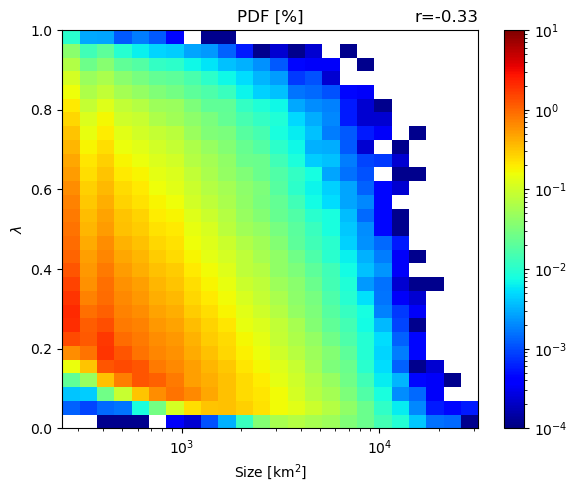

In [63]:
#
# Plot Figure 1 for paper
#
fig, ax = plt.subplots(figsize=(6, 5))


area = pf_stats['num_pixels'] * 25
loc = pf_stats[f'largest_10mmhr_cluster_precip_8conn'] / pf_stats['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)
count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic
pdf = 100 * count / count.sum()
x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
c = ax.pcolormesh(
    x_mesh, 
    y_mesh, 
    pdf, 
    cmap=plt.cm.jet, 
    norm=colors.LogNorm(vmin=1e-4, vmax=1e1)
)

# Compute Pearson's r for ocean (area vs. loc) and place in title (right)
r_val_ocean, p_val_ocean = pearsonr(area, loc)

plt.colorbar(c)
ax.set_xscale('log')
ax.set_xlim(area_bins.min(), area_bins.max())
ax.set_xlabel(r'Size [km$^2$]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('PDF [%]')
ax.set_title(f'r={r_val_ocean:.2f}', loc='right')

#
# Final figure params
#
fig.tight_layout(pad=1)
# save_figure(fig, 'Fig01_CDFandExamplePS')


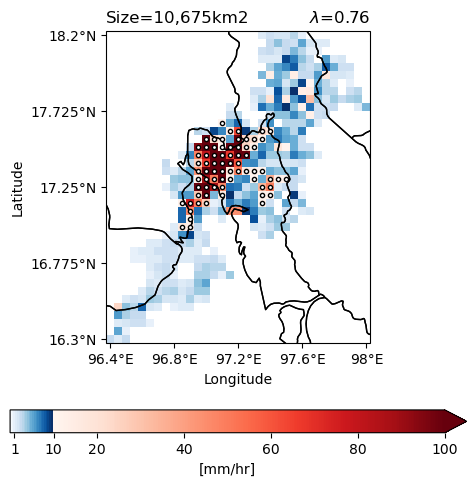

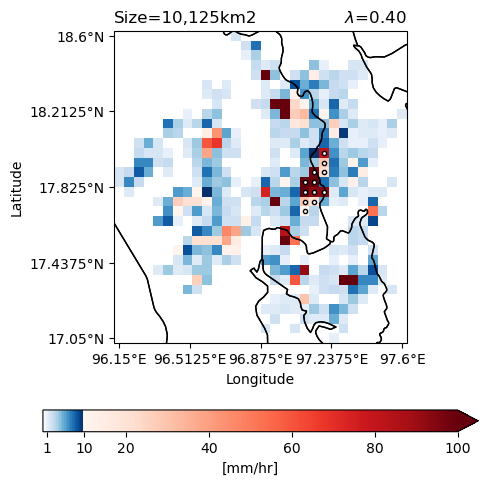

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import scipy.ndimage as ndimage
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Define a helper function to create the split colormap.
def create_split_cmap(vmin=0, vmax=100, split=10, cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm

# Create the split colormap.
cmap_split, norm_split = create_split_cmap(vmin=0, vmax=100, split=10)

# List of regimes corresponding to the two rain rate maps.
regime_list = ['high_area_high_loc', 'high_area_low_loc']

for idx, regime in enumerate(regime_list):
    # Open the dataset for the given regime.
    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data = xr.open_dataset(pf_filename)
    
    # Create a new figure for each regime.
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    # Plot the near-surface rain field using the split colormap.
    c = pf_data.near_surf_rain.plot(
        ax=ax,
        cmap=cmap_split,
        norm=norm_split,
        cbar_kwargs={'label': None, 'label': '[mm/hr]', 'orientation': 'horizontal', 'ticks': [1, 10, 20, 40, 60, 80, 100]}
    )

    
    # Extract the precipitation field as a NumPy array.
    rain = pf_data.near_surf_rain.values
    
    # Create a Boolean mask for rain rates exceeding 10 mm/hr.
    mask = rain > 10
    
    # Label connected regions using an 8-connected neighborhood.
    structure = np.ones((3, 3))
    labeled_array, num_features = ndimage.label(mask, structure=structure)
    
    if num_features > 0:
        # Compute the size of each connected region.
        region_sizes = ndimage.sum(mask, labeled_array, index=np.arange(1, num_features + 1))
        # Identify the label corresponding to the largest region.
        largest_region_label = np.argmax(region_sizes) + 1
        largest_region_mask = (labeled_array == largest_region_label)
        
        # Find the indices (row, col) of pixels in the largest region.
        indices = np.argwhere(largest_region_mask)
        
        # Get the coordinate arrays (adjust coordinate names if needed).
        lon = pf_data['lon'].values if 'lon' in pf_data.coords else pf_data['longitude'].values
        lat = pf_data['lat'].values if 'lat' in pf_data.coords else pf_data['latitude'].values
        
        # Loop over each pixel in the largest region and plot a white dot at its center.
        for i_idx, j_idx in indices:
            ax.plot(lon[j_idx], lat[i_idx], marker='o', color='white',
                    markersize=3, markeredgecolor='black')
    
    # Set axis labels.
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Compose a title with the date from the dataset (left) and a lambda value (right).
    date_str = pf_data.time.dt.strftime('%b %d, %Y').item() if 'time' in pf_data.coords else ''
    lambda_val = [0.76, 0.40][idx]  # Example lambda values for each regime.
    ax.set_title(None)
    # ax.set_title(f"{date_str}", loc='center')
    ax.set_title(rf"$\lambda$={lambda_val:.02f}", loc='right', size=12)
    ax.set_title(rf"Size={np.nansum(pf_data.near_surf_rain>=1)*25:,}km2", loc='left', size=12)
    # Optionally add state boundaries and coastlines.
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)
    
    # Add latitude and longitude ticks only on the bottom and left sides.
    ax.set_xticks(np.linspace(lon.min(), lon.max(), 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(lat.min(), lat.max(), 5), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labeltop=False, labelright=False)  # Only bottom and left ticks will be labeled.
    ax.set_aspect('equal')
    fig.tight_layout(pad=1)
    plt.show()


In [8]:
np.nansum(np.isnan(pf_data.near_surf_rain))*25

12300

In [67]:
pf_filename

'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/low_area_low_loc.nc'